In [1]:
import torch
import torch.nn.functional as F
import torchmetrics

import lightning as L

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from tests import test_category_embedder, test_house_price_regressor, print_dataset_info

B1. Data
---

a. Load the dataset using pandas

b. Create train, test and validation splits

c. Encode categorical features

d. Scale continuous features

e. Implement a PyTorch dataset

f. Create PyTorch dataloaders

### B1(a) Load the data using pandas

In [2]:
# Load the dataset
data = pd.read_csv("hdb_price_prediction.csv")

# Define continuous and categorical feature columns
continuous_cols = [
    "dist_to_nearest_stn",
    "dist_to_dhoby",
    "degree_centrality",
    "eigenvector_centrality",
    "remaining_lease_years",
    "floor_area_sqm",
]

categorical_cols = ["month", "town", "flat_model_type", "storey_range"]

# Inspect the data
print("Dataset shape:", data.shape)
print("\nColumns:\n", data.columns.tolist())
print("\nFirst 5 rows:\n", data.head())


Dataset shape: (159553, 14)

Columns:
 ['month', 'year', 'town', 'full_address', 'nearest_stn', 'dist_to_nearest_stn', 'dist_to_dhoby', 'degree_centrality', 'eigenvector_centrality', 'flat_model_type', 'remaining_lease_years', 'floor_area_sqm', 'storey_range', 'resale_price']

First 5 rows:
    month  year        town              full_address   nearest_stn  \
0      1  2017  ANG MO KIO  406 ANG MO KIO AVENUE 10    Ang Mo Kio   
1      1  2017  ANG MO KIO   108 ANG MO KIO AVENUE 4    Ang Mo Kio   
2      1  2017  ANG MO KIO   602 ANG MO KIO AVENUE 5  Yio Chu Kang   
3      1  2017  ANG MO KIO  465 ANG MO KIO AVENUE 10    Ang Mo Kio   
4      1  2017  ANG MO KIO   601 ANG MO KIO AVENUE 5  Yio Chu Kang   

   dist_to_nearest_stn  dist_to_dhoby  degree_centrality  \
0             1.007264       7.006044           0.016807   
1             1.271389       7.983837           0.016807   
2             1.069743       9.090700           0.016807   
3             0.946890       7.519889         

### B1(b) Temporal split with validation

Create a temporal split:

1.	Train/Val pool: all rows with year <= 2020.

2.	From this pool, randomly sample 10% of the dataset to create a validation set.

3.	Test set: all rows with year == 2021.

4.	Print shapes (n_rows, n_cols) for train_data, val_data, test_data.

In [3]:
# Create temporal pool
train_val_pool = data[data["year"] <= 2020]
test_data = data[data["year"] == 2021]

# From train_val_pool, randomly sample 10% for validation
train_data, val_data = train_test_split(
    train_val_pool,
    test_size=0.10,
    random_state=42,   # for reproducibility
    shuffle=True       # random sampling
)

# Print shapes to verify
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (78633, 14)
Validation data shape: (8737, 14)
Test data shape: (29057, 14)


In [4]:
# DO NOT MODIFY
train_data.shape, val_data.shape, test_data.shape

((78633, 14), (8737, 14), (29057, 14))

### B1(c) Encode categorical features w/o leakage

1.	Create an `sklearn.preprocessing.OrdinalEncoder` with handle_unknown="use_encoded_value", unknown_value=-1.

2.	Fit on train_data[categorical_cols] only.

3.	Transform val_data and test_data using the fitted encoder.

4. Compute and print the cardinality (number of distinct codes) for each categorical column on train_data after encoding. (These will be used to define embedding tables later.)

### B1(d) Scale continuous features w/o leakage

1.	Create a `StandardScaler`.

2.	Fit on train_data[continuous_cols] only.

3.	Transform val_data and test_data.

4.	Report the mean and std of each continuous feature on the transformed train split (they should be ~0 and ~1).

Do not scale resale_price.

In [5]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# -----------------------------------
# B1(c) Encode categorical features
# -----------------------------------

# Create the encoder
cat_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", 
    unknown_value=-1
)

# Fit on training split only (to prevent leakage)
cat_encoder.fit(train_data[categorical_cols])

# Transform all splits
train_data[categorical_cols] = cat_encoder.transform(train_data[categorical_cols])
val_data[categorical_cols]   = cat_encoder.transform(val_data[categorical_cols])
test_data[categorical_cols]  = cat_encoder.transform(test_data[categorical_cols])

# Compute and print cardinalities
cardinalities = {
    col: int(train_data[col].nunique())
    for col in categorical_cols
}

print("Categorical Feature Cardinalities:")
for col, card in cardinalities.items():
    print(f"{col}: {card}")

# -----------------------------------
# B1(d) Scale continuous features
# -----------------------------------

# Create scaler
cont_scaler = StandardScaler()

# Fit on training continuous features only
cont_scaler.fit(train_data[continuous_cols])

# Transform all splits
train_data[continuous_cols] = cont_scaler.transform(train_data[continuous_cols])
val_data[continuous_cols]   = cont_scaler.transform(val_data[continuous_cols])
test_data[continuous_cols]  = cont_scaler.transform(test_data[continuous_cols])

# Report mean and std on train split
print("\nTransformed Train Set (Continuous Feature Stats):")
mean_std = pd.DataFrame({
    'Mean': train_data[continuous_cols].mean().round(4),
    'Std': train_data[continuous_cols].std().round(4)
})
print(mean_std)


Categorical Feature Cardinalities:
month: 12
town: 26
flat_model_type: 43
storey_range: 17

Transformed Train Set (Continuous Feature Stats):
                        Mean  Std
dist_to_nearest_stn     -0.0  1.0
dist_to_dhoby            0.0  1.0
degree_centrality       -0.0  1.0
eigenvector_centrality  -0.0  1.0
remaining_lease_years    0.0  1.0
floor_area_sqm           0.0  1.0


C:\Users\tomas\AppData\Local\Temp\ipykernel_27784\3976695401.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[categorical_cols]  = cat_encoder.transform(test_data[categorical_cols])
C:\Users\tomas\AppData\Local\Temp\ipykernel_27784\3976695401.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[continuous_cols]  = cont_scaler.transform(test_data[continuous_cols])


In [6]:
# DO NOT MODIFY
train_data.shape, val_data.shape, test_data.shape

((78633, 14), (8737, 14), (29057, 14))

### B1(e) Implement a PyTorch Dataset

Implement HDBPriceDataset(Dataset) with:
- `__init__(self, data, categorical_cols, continuous_cols, target_col="resale_price")`

- `__getitem__(idx)` returns a dict: {"x_cat": LongTensor, "x_cont": FloatTensor, "y": FloatTensor}

In [7]:
from torch.utils.data import DataLoader, Dataset

class HDBPriceDataset(Dataset):
    def __init__(self, data, categorical_cols, continuous_cols, target_col="resale_price"):
        """
        PyTorch Dataset for HDB resale price prediction.
        
        Args:
            data (pd.DataFrame): preprocessed dataframe
            categorical_cols (list): list of categorical column names
            continuous_cols (list): list of continuous column names
            target_col (str): target column name (default: "resale_price")
        """
        self.data = data
        self.categorical_cols = categorical_cols
        self.continuous_cols = continuous_cols
        self.target_col = target_col

        # Extract relevant data arrays
        self.x_cat = torch.tensor(data[categorical_cols].values, dtype=torch.long)
        self.x_cont = torch.tensor(data[continuous_cols].values, dtype=torch.float32)
        self.y = torch.tensor(data[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "x_cat": self.x_cat[idx],
            "x_cont": self.x_cont[idx],
            "y": self.y[idx]
        }

### B1(f) Create train, validation and test data loaders

Create train, validation and test datasets and data loaders. Use a batch size of 1024

In [8]:
batch_size = 1024

train_dataset = HDBPriceDataset(train_data, categorical_cols, continuous_cols)
val_dataset   = HDBPriceDataset(val_data, categorical_cols, continuous_cols)
test_dataset  = HDBPriceDataset(test_data, categorical_cols, continuous_cols)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# DO NOT MODIFY
print_dataset_info(train_dataset, test_dataset, train_loader, test_loader)

Dataset info:
Train samples: 78,633
Test samples: 29,057
Total batches (train): 77
Total batches (test): 29

Sample batch shapes:
Categorical: torch.Size([1024, 4])
Continuous: torch.Size([1024, 6])
Target: torch.Size([1024])


B2. Model and training
---
a. Create a PyTorch Model

b. Write a LightningModule for fitting the model

c. Train the model

d. Predict using the trained model on the test set and calculate $R^2$

### B2(a) Create a PyTorch Model

In this part you will build a PyTorch model for tabular house-price regression that (i) embeds each categorical feature into a dense vector, (ii) concatenates all category embeddings with the standardized continuous features, and (iii) predicts resale_price via a small MLP.

You must implement two modules:
1.	CategoryEmbedder — one embedding table per categorical column plus optional dropout.

2.	HousePriceRegressor — uses CategoryEmbedder, concatenates with continuous features, then a 3-layer MLP.

You will then instantiate the model using provided cardinalities and embedding dimensions.

Use the same feature schema and encoded/scaled splits you produced in Part 1. Assume you already have train_loader, val_loader, test_loader, continuous_cols, oe (the fitted OrdinalEncoder), and batch_size.

A. Implement CategoryEmbedder (10 pts)

Create a module that receives:
- cardinalities: List[int] — number of distinct codes per categorical column (from oe.categories_).

- embed_dims: List[int] — embedding dimension for each categorical column (same length as cardinalities).

- emb_dropout: float — dropout applied after concatenation of all embeddings.

Requirements

1.	Construct a nn.ModuleList of nn.Embedding(num_embeddings=c, embedding_dim=d) for each (c, d) pair.

2.	In forward(x_cat), where x_cat has shape [B, C] (C = #categorical columns):

	- Look up each column i using its table: emb_i(x_cat[:, i]) → [B, d_i].

	- Concatenate along feature dimension → [B, sum(embed_dims)].

	- Apply Dropout(emb_dropout) and return.

In [10]:
import torch.nn as nn

class CategoryEmbedder(nn.Module):
    def __init__(self, cardinalities, embed_dims, emb_dropout=0.0):
        """Initialize the CategoryEmbedder.
        Args:
            cardinalities (list): List of integers representing the number of unique values for each categorical feature.
            embed_dims (list): List of integers representing the embedding dimensions for each categorical feature.
            embed_dropout (float): Dropout rate for the embeddings.
        """
        super().__init__()
        assert len(cardinalities) == len(embed_dims)
        self.embeddings = nn.ModuleList(
            [nn.Embedding(card, dim) for card, dim in zip(cardinalities, embed_dims)]
        )
        self.dropout = nn.Dropout(emb_dropout)

    def forward(self, x_cat: torch.Tensor) -> torch.Tensor:
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        return self.dropout(torch.cat(embs, dim=1))

In [11]:
test_category_embedder(CategoryEmbedder)

Test 1: Basic functionality
Input shape: torch.Size([32, 3])
Output shape: torch.Size([32, 14])
Expected output dim: 14
✓ Basic functionality test passed

Test 2: Single categorical feature
✓ Single feature test passed

Test 3: Edge case with minimum values
✓ Minimum values test passed

All tests passed! 🎉


In [12]:
class HousePriceRegressor(nn.Module):
    def __init__(self, cardinalities, embed_dims, n_continuous, emb_dropout=0.0):
        """Initialize the HousePriceRegressor.

        Args:
            cardinalities (list): List of integers representing the number of unique values for each categorical feature.
            embed_dims (list): List of integers representing the embedding dimensions for each categorical feature.
            n_continuous (int): Number of continuous features.
            emb_dropout (float, optional): Dropout rate for the embeddings. Defaults to 0.0.
        """
        super().__init__()
        self.embedder = CategoryEmbedder(cardinalities, embed_dims, emb_dropout)
        in_dim = sum(embed_dims) + n_continuous

        # 3-layer MLP head (no BatchNorm to avoid batch_size=1 issues in tests)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 128),    nn.ReLU(),
            nn.Linear(128, 64),     nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_cat, x_cont):
        emb = self.embedder(x_cat)                 # (B, sum(embed_dims))
        x = torch.cat([emb, x_cont], dim=1)        # (B, in_dim)
        out = self.mlp(x).squeeze(1)               # (B,)
        return out.float()

In [13]:
# alias to match the notebook's expected variable name
oe = cat_encoder

In [14]:
# DO NOT MODIFY
test_house_price_regressor(HousePriceRegressor)

Testing HousePriceRegressor...
Categorical input shape: torch.Size([32, 4])
Continuous input shape: torch.Size([32, 6])
Output shape: torch.Size([32])
Output type: torch.float32
Sample predictions: [0.05920391157269478, 0.14743869006633759, 0.1009318083524704, 0.10386553406715393, 0.084127277135849]
✓ Basic functionality test passed
✓ Batch size 1 test passed
✓ Batch size 16 test passed
✓ Batch size 64 test passed
✓ Batch size 128 test passed

Model info:
Total parameters: 51,781
Trainable parameters: 51,781

All HousePriceRegressor tests passed! 🎉


In [15]:
# DO NOT MODIFY
cardinalities = [len(categories) for categories in oe.categories_]
embedding_dims = [min(50, (c + 1) // 2) for c in cardinalities]
n_continuous = len(continuous_cols)

# Create model with proper cardinalities
model = HousePriceRegressor(
    cardinalities=cardinalities,
    embed_dims=embedding_dims,
    n_continuous=n_continuous,
    emb_dropout=0.1,
)

### B2(b) PyTorch LightningModule

Wrap your HousePriceRegressor into a PyTorch LightningModule so that training, validation, and testing are managed automatically.

What to do

1.	Initialize the module
    - Store hyperparameters (embedding sizes, number of continuous features, learning rate, etc.).

    - Create an instance of your HousePriceRegressor.

    - Choose a suitable regression loss function (e.g., MSE).

    - Set up at least one evaluation metric (e.g., MAE, RMSE).

2.	Forward method
    - Define a forward pass that takes categorical + continuous features and returns predictions.

3.	Training, Validation, and Test steps
    - In each step:
        - Extract features and target from the batch.

        - Run the model forward.

        - Compute the loss.

        - Log the loss and chosen metrics so they can be monitored.

4.	Prediction step
    - Implement a method to return predictions on new data without computing loss.

5.	Optimiser
    - Use a suitable optimiser (e.g., Adam) with a reasonable learning rate.

    - (Optional: add a scheduler if you wish to experiment.)

In [22]:
import lightning.pytorch as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

class HDBPriceLightningModule(L.LightningModule):
    def __init__(
        self,
        cardinalities,
        embedding_dims=None,   # test uses this name
        n_continuous=0,
        emb_dropout=0.0,
        learning_rate=1e-3,
        embed_dims=None,       # allows old name used by HousePriceRegressor
    ):
        super().__init__()
        # normalize the arg name
        if embedding_dims is None and embed_dims is None:
            raise ValueError("Provide embedding_dims (or embed_dims).")
        if embedding_dims is None:
            embedding_dims = embed_dims

        self.save_hyperparameters({
            "cardinalities": cardinalities,
            "embedding_dims": embedding_dims,
            "n_continuous": n_continuous,
            "emb_dropout": emb_dropout,
            "learning_rate": learning_rate,
        })

        # Model
        self.model = HousePriceRegressor(
            cardinalities=cardinalities,
            embed_dims=embedding_dims,   # HousePriceRegressor expects embed_dims
            n_continuous=n_continuous,
            emb_dropout=emb_dropout,
        )

        # Loss & metrics
        self.loss_fn = nn.MSELoss()
        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.val_mae   = torchmetrics.MeanAbsoluteError()
        self.test_mae  = torchmetrics.MeanAbsoluteError()

        self.train_rmse = torchmetrics.MeanSquaredError(squared=False)
        self.val_rmse   = torchmetrics.MeanSquaredError(squared=False)
        self.test_rmse  = torchmetrics.MeanSquaredError(squared=False)

        self.train_r2 = torchmetrics.R2Score()
        self.val_r2   = torchmetrics.R2Score()
        self.test_r2  = torchmetrics.R2Score()

    def forward(self, x_cat, x_cont):
        return self.model(x_cat, x_cont)

    def step(self, batch, stage):
        x_cat, x_cont, y = batch["x_cat"], batch["x_cont"], batch["y"]
        preds = self(x_cat, x_cont)
        loss = self.loss_fn(preds, y)

        if stage == "train":
            self.train_mae.update(preds, y); self.train_rmse.update(preds, y); self.train_r2.update(preds, y)
        elif stage == "val":
            self.val_mae.update(preds, y);   self.val_rmse.update(preds, y);   self.val_r2.update(preds, y)
        else:  # "test"
            self.test_mae.update(preds, y);  self.test_rmse.update(preds, y);  self.test_r2.update(preds, y)

        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx): return self.step(batch, "train")
    def validation_step(self, batch, batch_idx): return self.step(batch, "val")
    def test_step(self, batch, batch_idx): return self.step(batch, "test")

    def on_train_epoch_end(self):
        self.log("train_mae", self.train_mae.compute(), prog_bar=True)
        self.log("train_rmse", self.train_rmse.compute(), prog_bar=True)
        self.log("train_r2", self.train_r2.compute(), prog_bar=True)
        self.train_mae.reset(); self.train_rmse.reset(); self.train_r2.reset()

    def on_validation_epoch_end(self):
        self.log("val_mae", self.val_mae.compute(), prog_bar=True)
        self.log("val_rmse", self.val_rmse.compute(), prog_bar=True)
        self.log("val_r2", self.val_r2.compute(), prog_bar=True)
        self.val_mae.reset(); self.val_rmse.reset(); self.val_r2.reset()

    def on_test_epoch_end(self):
        self.log("test_mae", self.test_mae.compute(), prog_bar=True)
        self.log("test_rmse", self.test_rmse.compute(), prog_bar=True)
        self.log("test_r2", self.test_r2.compute(), prog_bar=True)
        self.test_mae.reset(); self.test_rmse.reset(); self.test_r2.reset()

    def predict_step(self, batch, batch_idx):
        return self(batch["x_cat"], batch["x_cont"])

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams["learning_rate"])

In [23]:
# DO NOT MODIFY
lightning_model = HDBPriceLightningModule(
    cardinalities=cardinalities,
    embedding_dims=embedding_dims,
    n_continuous=n_continuous,
    emb_dropout=0.1,
)

### B2(c) Train the model

What to do
1.	Checkpoints
    - Add a checkpoint callback that monitors validation loss and keeps the best models (e.g., top-k) plus the last checkpoint for resuming.

2.	Early stopping
    - Add early stopping on the same validation metric with a reasonable patience and a small min_delta (use a tiny positive value to require real improvement).

3.	Learning-rate tracking
    - Log the learning rate each epoch/step with a LR monitor so it’s visible in your logger.

4.	Experiment logging
    - Create a logger (e.g., TensorBoard) with a clear experiment name and save directory.

5.	Trainer configuration
    - Set a sensible number of epochs, devices/accelerator (CPU/GPU), and enable gradient clipping.

    - Turn on progress bar and model summary for visibility.

    - Choose an appropriate logging frequency for your dataset size.

6.	Fit & Test
- Call trainer.fit(model, train_loader, val_loader).

- Optionally run trainer.test(model, test_loader) after training and print metrics.

7. Download the plots for validation loss, your validation metric and display it.

In [25]:
max_epochs = 50

# Reproducibility
seed_everything(42, workers=True)

# Checkpoint callback (monitor val_loss)
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
    filename="best-{epoch:02d}-{val_loss:.3f}",
    verbose=True,
)

# Early stopping callback
early_stop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    min_delta=1e-4,  # require real improvement
    verbose=True,
)

# LR monitor
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Loggers: TensorBoard + CSV
tb_logger = TensorBoardLogger(save_dir="lightning_logs", name="hdb_price_regression")
csv_logger = CSVLogger(save_dir="lightning_logs", name="hdb_price_regression")

# Model
lightning_model = HDBPriceLightningModule(
    cardinalities=cardinalities,
    embedding_dims=embedding_dims,          # or embed_dims
    n_continuous=len(continuous_cols),
    emb_dropout=0.1,
    learning_rate=1e-3,
)

# Trainer
trainer = Trainer(
    max_epochs=max_epochs,
    accelerator="auto",
    devices="auto",
    gradient_clip_val=1.0,
    logger=[tb_logger, csv_logger],         # both TB and CSV
    callbacks=[checkpoint_cb, early_stop_cb, lr_monitor],
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True,
    deterministic=True,
)

# Fit
trainer.fit(
    model=lightning_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

# Test using the best checkpoint
trainer.test(ckpt_path="best", dataloaders=test_loader)

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name       | Type                | Params | Mode 
------------------------------------------------------------
0  | model      | HousePriceRegressor | 57.3 K | train
1  | loss_fn    | MSELoss             | 0      | train
2  | train_mae  | MeanAbsoluteError   | 0      | train
3  | val_mae    | MeanAbsoluteError   | 0      | train
4  | test_mae   | MeanAbsoluteError   | 0      | train
5  | train_rmse | MeanSquaredError    | 0      | train
6  | val_rmse   | MeanSquaredError    | 0      | train
7  | test_rmse  | MeanSquaredError    | 0      | train
8  | train_r2   | R2Score             | 0      | train
9  | val_r2     | R2Score             | 0      | train
10 | test_r2    | R2Score             | 0      | train
------------------------------------------------------------
57.3 K    Trainable params
0         Non-trainable params
57.3 K    Total params
0.229     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\tomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 215337598976.000
Epoch 0, global step 77: 'val_loss' reached 215337598976.00000 (best 215337598976.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=00-val_loss=215337598976.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 7245725696.000 >= min_delta = 0.0001. New best score: 208091873280.000
Epoch 1, global step 154: 'val_loss' reached 208091873280.00000 (best 208091873280.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=01-val_loss=208091873280.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 30161469440.000 >= min_delta = 0.0001. New best score: 177930403840.000
Epoch 2, global step 231: 'val_loss' reached 177930403840.00000 (best 177930403840.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=02-val_loss=177930403840.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 71932674048.000 >= min_delta = 0.0001. New best score: 105997729792.000
Epoch 3, global step 308: 'val_loss' reached 105997729792.00000 (best 105997729792.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=03-val_loss=105997729792.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 81275002880.000 >= min_delta = 0.0001. New best score: 24722724864.000
Epoch 4, global step 385: 'val_loss' reached 24722724864.00000 (best 24722724864.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=04-val_loss=24722724864.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 15747977216.000 >= min_delta = 0.0001. New best score: 8974747648.000
Epoch 5, global step 462: 'val_loss' reached 8974747648.00000 (best 8974747648.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=05-val_loss=8974747648.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 4574886400.000 >= min_delta = 0.0001. New best score: 4399861248.000
Epoch 6, global step 539: 'val_loss' reached 4399861248.00000 (best 4399861248.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=06-val_loss=4399861248.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 940186112.000 >= min_delta = 0.0001. New best score: 3459675136.000
Epoch 7, global step 616: 'val_loss' reached 3459675136.00000 (best 3459675136.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=07-val_loss=3459675136.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 309692928.000 >= min_delta = 0.0001. New best score: 3149982208.000
Epoch 8, global step 693: 'val_loss' reached 3149982208.00000 (best 3149982208.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=08-val_loss=3149982208.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 174618112.000 >= min_delta = 0.0001. New best score: 2975364096.000
Epoch 9, global step 770: 'val_loss' reached 2975364096.00000 (best 2975364096.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=09-val_loss=2975364096.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 134445312.000 >= min_delta = 0.0001. New best score: 2840918784.000
Epoch 10, global step 847: 'val_loss' reached 2840918784.00000 (best 2840918784.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=10-val_loss=2840918784.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 77488640.000 >= min_delta = 0.0001. New best score: 2763430144.000
Epoch 11, global step 924: 'val_loss' reached 2763430144.00000 (best 2763430144.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=11-val_loss=2763430144.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 47588864.000 >= min_delta = 0.0001. New best score: 2715841280.000
Epoch 12, global step 1001: 'val_loss' reached 2715841280.00000 (best 2715841280.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=12-val_loss=2715841280.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 80877056.000 >= min_delta = 0.0001. New best score: 2634964224.000
Epoch 13, global step 1078: 'val_loss' reached 2634964224.00000 (best 2634964224.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=13-val_loss=2634964224.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 79831552.000 >= min_delta = 0.0001. New best score: 2555132672.000
Epoch 14, global step 1155: 'val_loss' reached 2555132672.00000 (best 2555132672.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=14-val_loss=2555132672.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 75097344.000 >= min_delta = 0.0001. New best score: 2480035328.000
Epoch 15, global step 1232: 'val_loss' reached 2480035328.00000 (best 2480035328.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=15-val_loss=2480035328.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 70240512.000 >= min_delta = 0.0001. New best score: 2409794816.000
Epoch 16, global step 1309: 'val_loss' reached 2409794816.00000 (best 2409794816.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=16-val_loss=2409794816.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 89588480.000 >= min_delta = 0.0001. New best score: 2320206336.000
Epoch 17, global step 1386: 'val_loss' reached 2320206336.00000 (best 2320206336.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=17-val_loss=2320206336.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 95796736.000 >= min_delta = 0.0001. New best score: 2224409600.000
Epoch 18, global step 1463: 'val_loss' reached 2224409600.00000 (best 2224409600.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=18-val_loss=2224409600.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 91155712.000 >= min_delta = 0.0001. New best score: 2133253888.000
Epoch 19, global step 1540: 'val_loss' reached 2133253888.00000 (best 2133253888.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=19-val_loss=2133253888.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 101020032.000 >= min_delta = 0.0001. New best score: 2032233856.000
Epoch 20, global step 1617: 'val_loss' reached 2032233856.00000 (best 2032233856.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=20-val_loss=2032233856.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 76380032.000 >= min_delta = 0.0001. New best score: 1955853824.000
Epoch 21, global step 1694: 'val_loss' reached 1955853824.00000 (best 1955853824.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=21-val_loss=1955853824.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 59552768.000 >= min_delta = 0.0001. New best score: 1896301056.000
Epoch 22, global step 1771: 'val_loss' reached 1896301056.00000 (best 1896301056.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=22-val_loss=1896301056.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 47544704.000 >= min_delta = 0.0001. New best score: 1848756352.000
Epoch 23, global step 1848: 'val_loss' reached 1848756352.00000 (best 1848756352.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=23-val_loss=1848756352.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 42094080.000 >= min_delta = 0.0001. New best score: 1806662272.000
Epoch 24, global step 1925: 'val_loss' reached 1806662272.00000 (best 1806662272.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=24-val_loss=1806662272.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 33724160.000 >= min_delta = 0.0001. New best score: 1772938112.000
Epoch 25, global step 2002: 'val_loss' reached 1772938112.00000 (best 1772938112.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=25-val_loss=1772938112.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 2079: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 49859712.000 >= min_delta = 0.0001. New best score: 1723078400.000
Epoch 27, global step 2156: 'val_loss' reached 1723078400.00000 (best 1723078400.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=27-val_loss=1723078400.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 19972352.000 >= min_delta = 0.0001. New best score: 1703106048.000
Epoch 28, global step 2233: 'val_loss' reached 1703106048.00000 (best 1703106048.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=28-val_loss=1703106048.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 12316544.000 >= min_delta = 0.0001. New best score: 1690789504.000
Epoch 29, global step 2310: 'val_loss' reached 1690789504.00000 (best 1690789504.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=29-val_loss=1690789504.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 9114624.000 >= min_delta = 0.0001. New best score: 1681674880.000
Epoch 30, global step 2387: 'val_loss' reached 1681674880.00000 (best 1681674880.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=30-val_loss=1681674880.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 21803520.000 >= min_delta = 0.0001. New best score: 1659871360.000
Epoch 31, global step 2464: 'val_loss' reached 1659871360.00000 (best 1659871360.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=31-val_loss=1659871360.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1381376.000 >= min_delta = 0.0001. New best score: 1658489984.000
Epoch 32, global step 2541: 'val_loss' reached 1658489984.00000 (best 1658489984.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=32-val_loss=1658489984.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 17869824.000 >= min_delta = 0.0001. New best score: 1640620160.000
Epoch 33, global step 2618: 'val_loss' reached 1640620160.00000 (best 1640620160.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=33-val_loss=1640620160.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 8505472.000 >= min_delta = 0.0001. New best score: 1632114688.000
Epoch 34, global step 2695: 'val_loss' reached 1632114688.00000 (best 1632114688.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=34-val_loss=1632114688.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 15233280.000 >= min_delta = 0.0001. New best score: 1616881408.000
Epoch 35, global step 2772: 'val_loss' reached 1616881408.00000 (best 1616881408.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=35-val_loss=1616881408.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 9869824.000 >= min_delta = 0.0001. New best score: 1607011584.000
Epoch 36, global step 2849: 'val_loss' reached 1607011584.00000 (best 1607011584.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=36-val_loss=1607011584.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 6505984.000 >= min_delta = 0.0001. New best score: 1600505600.000
Epoch 37, global step 2926: 'val_loss' reached 1600505600.00000 (best 1600505600.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=37-val_loss=1600505600.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11915904.000 >= min_delta = 0.0001. New best score: 1588589696.000
Epoch 38, global step 3003: 'val_loss' reached 1588589696.00000 (best 1588589696.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=38-val_loss=1588589696.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 5760128.000 >= min_delta = 0.0001. New best score: 1582829568.000
Epoch 39, global step 3080: 'val_loss' reached 1582829568.00000 (best 1582829568.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=39-val_loss=1582829568.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11276672.000 >= min_delta = 0.0001. New best score: 1571552896.000
Epoch 40, global step 3157: 'val_loss' reached 1571552896.00000 (best 1571552896.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=40-val_loss=1571552896.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 447744.000 >= min_delta = 0.0001. New best score: 1571105152.000
Epoch 41, global step 3234: 'val_loss' reached 1571105152.00000 (best 1571105152.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=41-val_loss=1571105152.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 7098112.000 >= min_delta = 0.0001. New best score: 1564007040.000
Epoch 42, global step 3311: 'val_loss' reached 1564007040.00000 (best 1564007040.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=42-val_loss=1564007040.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 14572288.000 >= min_delta = 0.0001. New best score: 1549434752.000
Epoch 43, global step 3388: 'val_loss' reached 1549434752.00000 (best 1549434752.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=43-val_loss=1549434752.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 3465: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11193984.000 >= min_delta = 0.0001. New best score: 1538240768.000
Epoch 45, global step 3542: 'val_loss' reached 1538240768.00000 (best 1538240768.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=45-val_loss=1538240768.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3973120.000 >= min_delta = 0.0001. New best score: 1534267648.000
Epoch 46, global step 3619: 'val_loss' reached 1534267648.00000 (best 1534267648.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=46-val_loss=1534267648.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 11550592.000 >= min_delta = 0.0001. New best score: 1522717056.000
Epoch 47, global step 3696: 'val_loss' reached 1522717056.00000 (best 1522717056.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=47-val_loss=1522717056.000.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 3773: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 19657216.000 >= min_delta = 0.0001. New best score: 1503059840.000
Epoch 49, global step 3850: 'val_loss' reached 1503059840.00000 (best 1503059840.00000), saving model to 'lightning_logs\\hdb_price_regression\\version_3\\checkpoints\\best-epoch=49-val_loss=1503059840.000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.
Restoring states from the checkpoint path at lightning_logs\hdb_price_regression\version_3\checkpoints\best-epoch=49-val_loss=1503059840.000.ckpt
Loaded model weights from the checkpoint at lightning_logs\hdb_price_regression\version_3\checkpoints\best-epoch=49-val_loss=1503059840.000.ckpt
c:\Users\tomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       5216788992.0        │
│         test_mae          │        60466.34375        │
│          test_r2          │    0.8027827739715576     │
│         test_rmse         │        72227.34375        │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5216788992.0,
  'test_mae': 60466.34375,
  'test_rmse': 72227.34375,
  'test_r2': 0.8027827739715576}]

metrics.csv columns: ['epoch', 'lr-Adam', 'step', 'test_loss', 'test_mae', 'test_r2', 'test_rmse', 'train_loss', 'train_mae', 'train_r2', 'train_rmse', 'val_loss', 'val_mae', 'val_r2', 'val_rmse']
   epoch  lr-Adam  step  test_loss  test_mae  test_r2  test_rmse  \
0    NaN    0.001     0        NaN       NaN      NaN        NaN   
1    0.0      NaN    76        NaN       NaN      NaN        NaN   
2    0.0      NaN    76        NaN       NaN      NaN        NaN   
3    NaN    0.001    77        NaN       NaN      NaN        NaN   
4    1.0      NaN   153        NaN       NaN      NaN        NaN   
5    1.0      NaN   153        NaN       NaN      NaN        NaN   
6    NaN    0.001   154        NaN       NaN      NaN        NaN   
7    2.0      NaN   230        NaN       NaN      NaN        NaN   

     train_loss    train_mae  train_r2    train_rmse      val_loss  \
0           NaN          NaN       NaN           NaN           NaN   
1           NaN          NaN       NaN           N

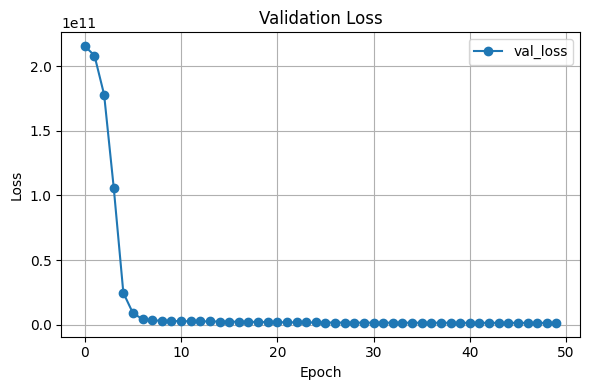

Saved: lightning_logs\hdb_price_regression\version_4\val_loss.png


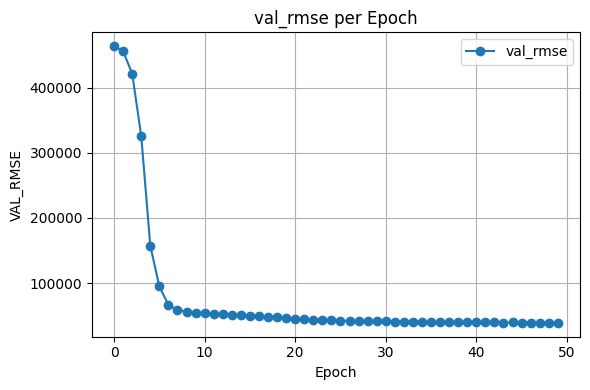

Saved: lightning_logs\hdb_price_regression\version_4\val_rmse.png


In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt

log_dir = csv_logger.log_dir  # e.g. lightning_logs/hdb_price_regression/version_0
metrics_csv = os.path.join(log_dir, "metrics.csv")
assert os.path.exists(metrics_csv), f"metrics.csv not found at {metrics_csv}"

df = pd.read_csv(metrics_csv)

# ---- Inspect columns (helps debug if needed) ----
print("metrics.csv columns:", list(df.columns))
print(df.head(8))

# Helper to pick the first existing key
def pick_key(candidates, columns):
    for k in candidates:
        if k in columns:
            return k
    return None

epoch_key = pick_key(["epoch", "epoch_0"], df.columns)  # lightning uses 'epoch'
if epoch_key is None:
    raise RuntimeError("No 'epoch' column in metrics.csv; cannot plot per-epoch.")

# Try both non-epoch and *_epoch names
val_loss_key   = pick_key(["val_loss", "val_loss_epoch"], df.columns)
val_metric_key = pick_key(["val_rmse", "val_rmse_epoch", "val_mae", "val_mae_epoch", "val_r2", "val_r2_epoch"], df.columns)

# Group by epoch and take the last non-NaN per epoch (works for both step/epoch logging)
def last_non_nan(series):
    s = series.dropna()
    return s.iloc[-1] if len(s) else float("nan")

agg = {}
if val_loss_key:   agg[val_loss_key]   = last_non_nan
if val_metric_key: agg[val_metric_key] = last_non_nan

if not agg:
    raise RuntimeError(
        "Could not find validation loss/metric columns. "
        "Check printed columns above and adjust the candidate names."
    )

per_epoch = df.groupby(epoch_key, as_index=True).agg(agg).reset_index()

# ---- Plot validation loss ----
if val_loss_key and per_epoch[val_loss_key].notna().any():
    plt.figure(figsize=(6,4))
    plt.plot(per_epoch[epoch_key], per_epoch[val_loss_key], marker="o", label=val_loss_key)
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Validation Loss")
    plt.grid(True); plt.legend(); plt.tight_layout()
    out_path = os.path.join(log_dir, "val_loss.png")
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)
else:
    print("No non-NaN values to plot for validation loss.")

# ---- Plot validation metric ----
if val_metric_key and per_epoch[val_metric_key].notna().any():
    plt.figure(figsize=(6,4))
    plt.plot(per_epoch[epoch_key], per_epoch[val_metric_key], marker="o", label=val_metric_key)
    plt.xlabel("Epoch"); plt.ylabel(val_metric_key.upper()); plt.title(f"{val_metric_key} per Epoch")
    plt.grid(True); plt.legend(); plt.tight_layout()
    out_path = os.path.join(log_dir, f"{val_metric_key}.png")
    plt.savefig(out_path, dpi=150)
    plt.show()
    print("Saved:", out_path)
else:
    print("No non-NaN values to plot for validation metric.")


### B2(d) Model prediction and evaluation

1.	Run prediction
    - Use trainer.predict(model, test_loader) to generate predictions on the held-out test set.

    - Concatenate predictions into a single tensor/array.

2. Report results
    - Print R² (rounded to 4 decimal places).

    - Interpret the value of R² briefly

In [27]:
# ---- Run prediction on test set ----
predictions = trainer.predict(lightning_model, dataloaders=test_loader)
# predictions is a list of batches, each a tensor of shape (B,)
preds_tensor = torch.cat(predictions, dim=0)  # shape: (N,)

# Get ground truth targets from test set (in order)
y_test_true = torch.cat([batch["y"] for batch in test_loader], dim=0)

# ---- Convert to numpy for R^2 calculation ----
y_true_np = y_test_true.detach().cpu().numpy()
y_pred_np = preds_tensor.detach().cpu().numpy()

# ---- Compute R^2 ----
from sklearn.metrics import r2_score

r2 = r2_score(y_true_np, y_pred_np)
print(f"R^2 on test set = {r2:.4f}")


c:\Users\tomas\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

R^2 on test set = 0.8028


B3. Model Interpretability with Integrated Gradients
---

 What to do
1.	Choose an explainability method

    - Use Integrated Gradients (IG) from captum.attr.

    - Treat the continuous features (x_cont) as the primary inputs for attribution.

    - Pass categorical features (x_cat) as additional arguments to the forward function.

2.	Define a forward wrapper

    - Implement a wrapper function so IG knows how to call your model with both categorical and continuous features.

3.	Local explanation (per sample)

    - Run IG on a single batch from the training set.

    - Use a zero baseline for continuous features.

    - Plot the continuous features ranked by signed contribution for one example.

4.	Global explanation (across dataset)

    - Loop over the validation set to compute mean absolute attributions for each continuous feature.

    - Normalize by the number of samples.

    - Rank features by importance and plot a bar chart showing the most influential features globally.

5.	Interpret results

    - Report which features matter most for the model’s predictions.

    - Reflect briefly: Do these align with intuition (e.g., distance to station, floor area)?

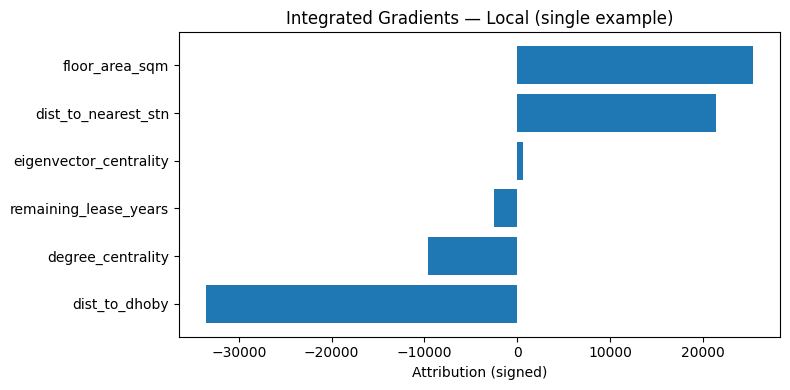

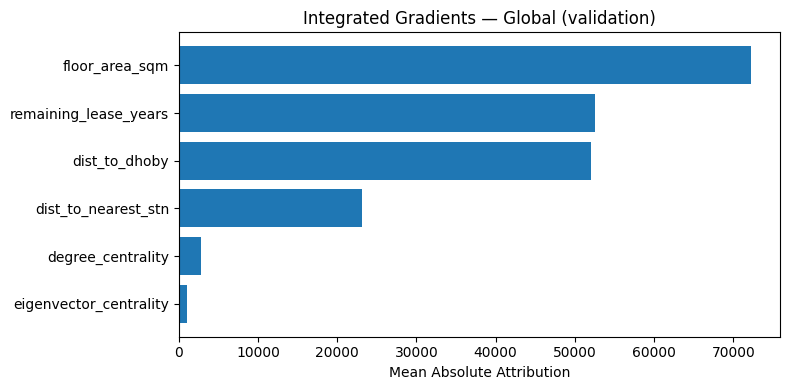

Top features (global IG ranking):
floor_area_sqm                 | 72282.9297
remaining_lease_years          | 52486.6875
dist_to_dhoby                  | 52033.7539
dist_to_nearest_stn            | 23162.1016
degree_centrality              | 2767.7429
eigenvector_centrality         | 986.0476


In [28]:
import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

# ---- Device & model ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lightning_model.eval().to(device)
model = lightning_model.model.to(device)  # raw nn.Module
model.eval()

# Wrapper: IG will call with inputs first (x_cont), then additional args (x_cat)
def model_forward(x_cont, x_cat):
    return model(x_cat, x_cont)  # your regressor expects (x_cat, x_cont)

# ---- Local explanation on one training sample ----
sample_batch = next(iter(train_loader))
x_cat_batch = sample_batch["x_cat"].to(device)
x_cont_batch = sample_batch["x_cont"].to(device)

x_cat_single = x_cat_batch[0].unsqueeze(0)          # (1, C)
x_cont_single = x_cont_batch[0].unsqueeze(0)        # (1, D)
x_cont_single = x_cont_single.requires_grad_()      # <— important for IG

baseline_cont = torch.zeros_like(x_cont_single)

ig = IntegratedGradients(model_forward)

# Use a reasonable number of steps for smoother integral approximation
attr = ig.attribute(
    inputs=x_cont_single,
    baselines=baseline_cont,
    additional_forward_args=x_cat_single,
    n_steps=64,
)

attr_np = attr.squeeze(0).detach().cpu().numpy()

# Plot signed contributions (local)
cont_feat_names = continuous_cols
plt.figure(figsize=(8, 4))
sorted_idx = np.argsort(attr_np)
plt.barh(np.array(cont_feat_names)[sorted_idx], attr_np[sorted_idx])
plt.xlabel("Attribution (signed)")
plt.title("Integrated Gradients — Local (single example)")
plt.tight_layout()
plt.show()

# ---- Global explanation over validation set ----
attr_sum = torch.zeros(len(continuous_cols), device=device)
n_samples = 0

for batch in val_loader:
    x_cat = batch["x_cat"].to(device)
    x_cont = batch["x_cont"].to(device).requires_grad_()   # <— enable grads
    baseline = torch.zeros_like(x_cont)

    attr = ig.attribute(
        inputs=x_cont,
        baselines=baseline,
        additional_forward_args=x_cat,
        n_steps=64,
    )  # shape (B, D)

    # accumulate |IG|
    attr_sum += attr.abs().sum(dim=0)  # (D,)
    n_samples += x_cont.size(0)

global_attr = (attr_sum / n_samples).detach().cpu().numpy()

plt.figure(figsize=(8, 4))
sorted_idx = np.argsort(global_attr)
plt.barh(np.array(continuous_cols)[sorted_idx], global_attr[sorted_idx])
plt.xlabel("Mean Absolute Attribution")
plt.title("Integrated Gradients — Global (validation)")
plt.tight_layout()
plt.show()

# Print ranking for reporting
global_feat_importance = list(zip(continuous_cols, global_attr))
ranked = sorted(global_feat_importance, key=lambda x: -x[1])
print("Top features (global IG ranking):")
for name, score in ranked:
    print(f"{name:30s} | {score:.4f}")

Interpretation:
The most influential features (globally) are `floor_area_sqm`, `remaining_lease_years`, and `dist_to_dhoby` (where a greater distance contributes negatively to price), which align with common sense — larger flats, newer leases, and proximity to central areas like Dhoby Ghaut typically drive higher prices.

Local explanation also allows us to see why the model predicted a specific resale price for a single flat, highlighting the most positive and negative drivers. For example, for the illustrated flat, `floor_area_sqm` contributed most upward, while `dist_to_dhoby` contributed most downward.